# **W1D3: Remote Sensing for Climate**

# **Tutorial 4: Understanding Climatology Through Precipitation Data**

**Week 1, Day 3, Remote Sensing**

**Content creators:** Douglas Rao

**Content reviewers:** Katrina Dobson, Younkap Nina Duplex, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Jenna Pearson, Agustina Pesce, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**

In this tutorial, you will explore the concept of a climatology, and learn how to leverage it using satellite precipitation data. You have already practiced how to calcuate a climatology using temperature data in the overview of the climate system day. That data spanned only 14 years, and typically you would want your data to span at least 30 years to calculate a climatology. Here you will use data spanning several decades to explore the seasonal cycle of precpitation at a specific location.

Upon completing this tutorial, you'll be able to:

- Comprehend the fundamentals of climatologies.
- Compute a climatology utilizing long-term satellite precipitation data.
- Create informative maps including features such as projections, coastlines, and other advanced plotting components.

Throughout this tutorial, you'll employ NOAA's monthly precipitation climate data records as the primary resource to demonstrate the process of calculating a long-term climatology for climate analysis. Specifically, you'll use the [Global Precipitation Climatology Project (GPCP) Monthly Precipitation Climate Data Record (CDR)](https://www.ncei.noaa.gov/products/climate-data-records/precipitation-gpcp-monthly). As part of your investigation, you'll focus on a specific location, observing its data across the entire time duration covered by the GPCP monthly dataset.

# **Setup**

In [1]:
# !pip install s3fs --quiet

# properly install cartopy in colab to avoid session crash
# !apt-get install libproj-dev proj-data proj-bin --quiet
# !apt-get install libgeos-dev --quiet
# !pip install cython --quiet
# !pip install cartopy --quiet

# !apt-get -qq install python-cartopy python3-cartopy  --quiet
# !pip uninstall -y shapely  --quiet
# !pip install shapely --no-binary shapely  --quiet

In [2]:
# imports
import s3fs
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import boto3
import botocore
import pooch

In [3]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

In [4]:
# @title Video 1: Video 1 Name
#Tech team will add code to format and display the video

# **Section 1: Obtain Monthly Precipitation Data**



In this tutorial, the objective is to demonstrate how to calculate the long-term precipitation climatology using monthly precipitation climate data records from NOAA. 

You'll be utilizing the [Global Precipitation Climatology Project (GPCP) Monthly Precipitation Climate Data Record (CDR)](https://www.ncei.noaa.gov/products/climate-data-records/precipitation-gpcp-monthly). This dataset contains monthly satellite-gauge data and corresponding precipitation error estimates from January 1979 to the present, gridded at a 2.5°×2.5° resolution. *Satellite-gauge* means that the climate data record (CDR) is a compilation of precipitation data from multiple satellites and in-situ sources, combined into a final product that optimizes the advantages of each type of data.

While a higher spatial resolution (1°×1°) at daily resolution exists for varied applications, we will restrict ourselves to the coarser resolution monthly data due to computational limitations. However, you are encouraged to delve into the daily higher resolution data for your specific project needs.


## **Section 1.1: Access GPCP Monthly CDR Data on AWS**

To perform analysis, we will need to access the monthly data files from AWS first. We will use the skills that we learned from last tutorial on accessing data from an AWS S3 bucket.

In [5]:
# connect to the AWS S3 bucket for the GPCP Monthly Precipitation CDR data
fs = s3fs.S3FileSystem(anon=True)

# get the list of all data files in the AWS S3 bucket fit the data file pattern.
file_pattern = 'noaa-cdr-precip-gpcp-monthly-pds/data/*/gpcp_v02r03_monthly_*.nc'
file_location = fs.glob(file_pattern)

In [6]:
print("Total number of GPCP Monthly precipitation data files:")
print(len(file_location))

Total number of GPCP Monthly precipitation data files:
530


We have more than 500 GPCP monthly precipitation CDR data files in the AWS S3 bucket. Each data file contains the data of each month globally starting from January 1979. Now, let's open a single data file to look at the data structure before we open all data files.

In [7]:
# first, open a client connection
client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED)) # initialize aws s3 bucket client

# read single data file to understand the file structure
ds_single = xr.open_dataset(pooch.retrieve('http://s3.amazonaws.com/'+file_location[0],known_hash=None )) # open the file

# check how many variables are inluded in one data file
ds_single.data_vars 


Data variables:
    lat_bounds    (latitude, nv) float32 ...
    lon_bounds    (longitude, nv) float32 ...
    time_bounds   (time, nv) datetime64[ns] ...
    precip        (time, latitude, longitude) float32 ...
    precip_error  (time, latitude, longitude) float32 ...

From the information provided by `xarray`, there are a total of five data variables in this monthly data file, including `precip` for the monthly precipitation and `precip_error` for the monthly precipitation error.


In [8]:
# check the coordinates for the data file
ds_single.coords

Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time       (time) datetime64[ns] 1979-01-01

All data is organized in three dimensions: `latitude`, `longitude`, and `time`. We want to create a three-dimensional data array for the monthly precipitation data across the entire data period (from January 1979 until present) so we must open all the available files

In [9]:
# open all the monthly data files
# this process will take ~ 5 minute to complete due to the number of data files.

file_ob = [pooch.retrieve('http://s3.amazonaws.com/'+file,known_hash=None ) for file in file_location]

In [10]:
# using this function instead of 'open_dataset' will concatenate the data along the dimension we specify
ds = xr.open_mfdataset(file_ob, combine='nested', concat_dim='time')
ds

<xarray.Dataset>
Dimensions:       (latitude: 72, longitude: 144, time: 530, nv: 2)
Coordinates:
  * latitude      (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude     (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time          (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-02-01
Dimensions without coordinates: nv
Data variables:
    lat_bounds    (time, latitude, nv) float32 dask.array<chunksize=(1, 72, 2), meta=np.ndarray>
    lon_bounds    (time, longitude, nv) float32 dask.array<chunksize=(1, 144, 2), meta=np.ndarray>
    time_bounds   (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    precip        (time, latitude, longitude) float32 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
    precip_error  (time, latitude, longitude) float32 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                CF-1.6, ACDD 1.3
    title:                      Global Precipitation Climatatology Project (G...
    source:                     oc.197901.sg
    references:                 Huffman et al. 1997, http://dx.doi.org/10.117...
    history:                    1) �R
`�, Dr. Jian-Jian Wang, U of Maryland,...
    Metadata_Conventions:       CF-1.6, Unidata Dataset Discovery v1.0, NOAA ...
    ...                         ...
    metadata_link:              gov.noaa.ncdc:C00979
    product_version:            v23rB1
    platform:                   NOAA POES (Polar Orbiting Environmental Satel...
    sensor:                     AVHRR>Advanced Very High Resolution Radiometer
    spatial_resolution:         2.5 degree
    comment:                    Processing computer: eagle2.umd.edu

In the above code, we used `combine='nested', concat_dim='time'` to combine all monthly precipitation data into one data array along the dimension of `time`. This command is very useful when reading in multiple data files of the same structure but covering different parts of the full data record.

Since we are interested in the precipitation data globally at this moment, let's extract the entire data array of precipitation from the entire dataset.

In [12]:
# Examine the precipitation data variable
precip = ds.precip
precip

<xarray.DataArray 'precip' (time: 530, latitude: 72, longitude: 144)>
dask.array<concatenate, shape=(530, 72, 144), dtype=float32, chunksize=(1, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-02-01
Attributes:
    long_name:      NOAA Climate Data Record (CDR) of GPCP Monthly Satellite-...
    standard_name:  precipitation amount
    units:          mm/day
    valid_range:    [  0. 100.]
    cell_methods:   area: mean time: mean

As you can see, the data array has the dimensions of `time` `longitude` `latitude`. Before delving into further analysis, let's visualize the precipitation data to gain a better understanding of its patterns and characteristics. 

## **Section 1.2: Visualize GPCP Data Using Cartopy**

In previous tutorials, we've learned how to make simple visualization using `matplotlib` using `latitude` and `longitude` as the y-axis and x-axis.

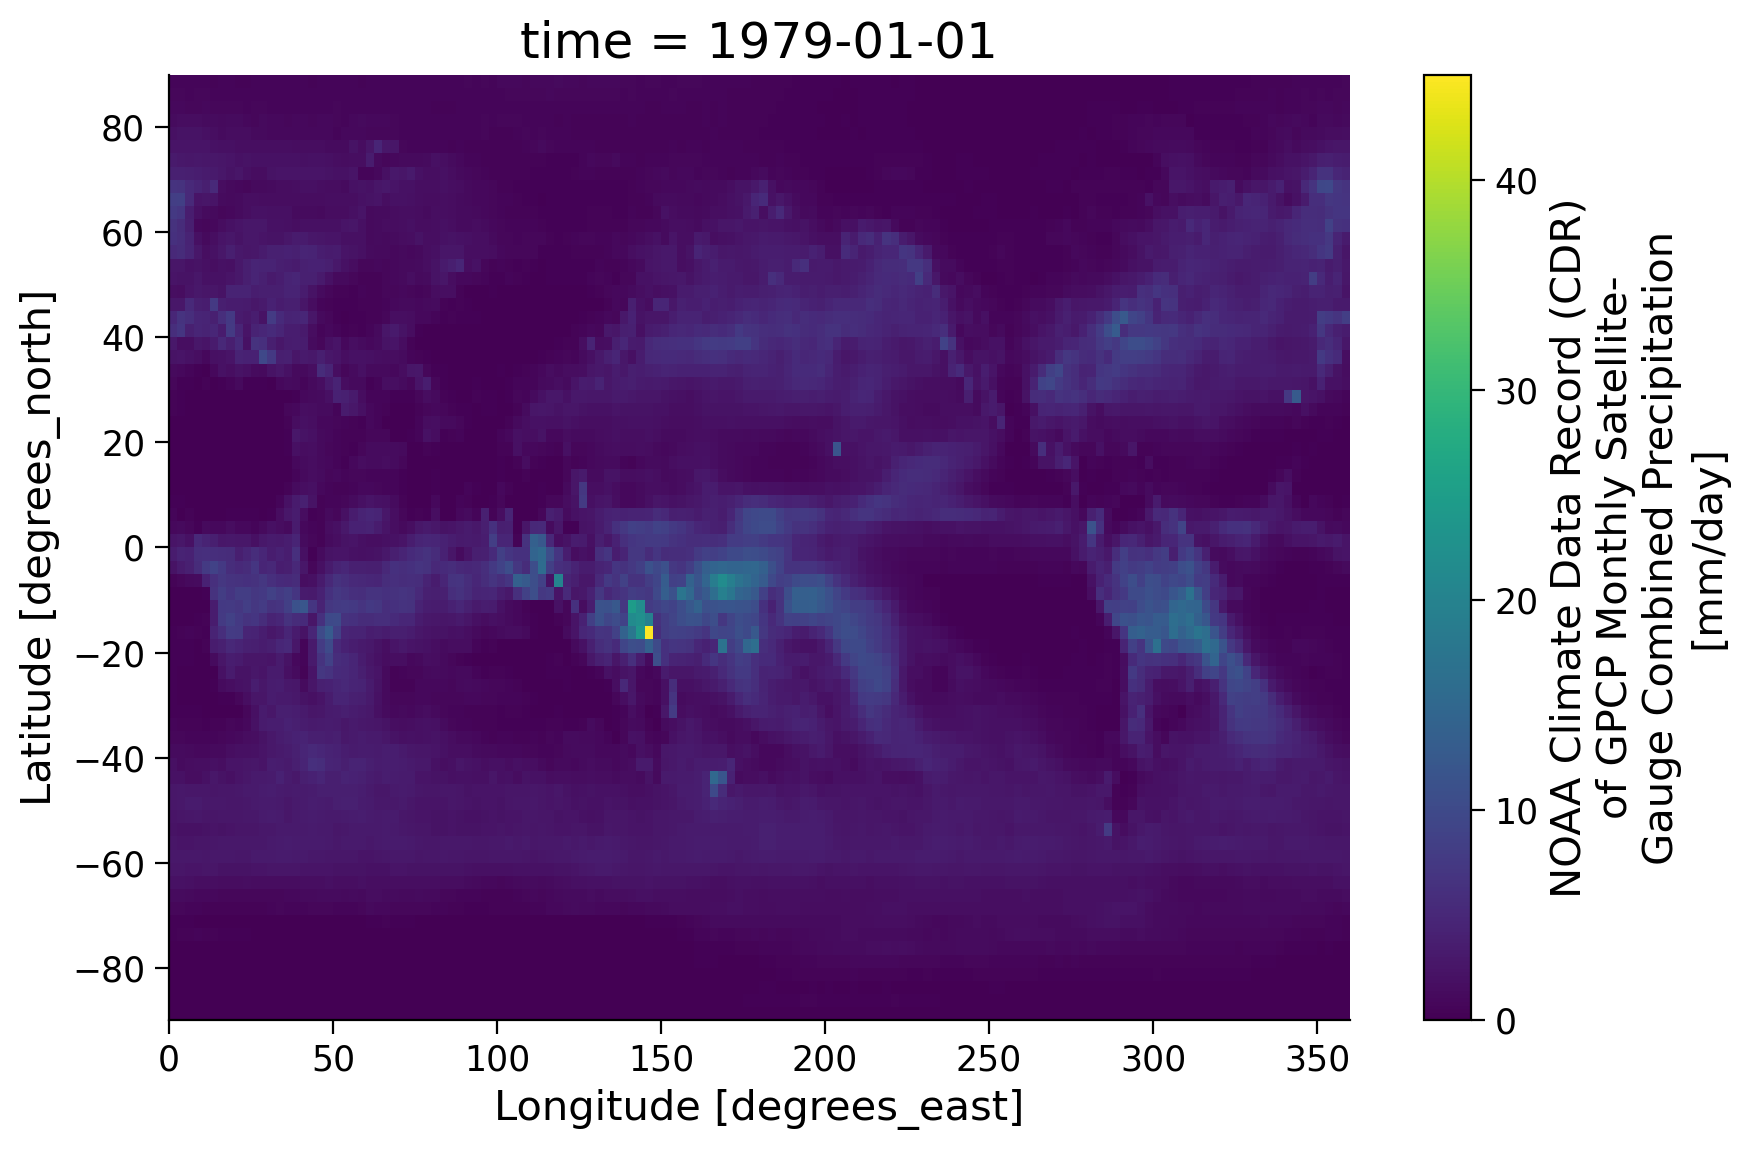

In [13]:
# create simple map of the GPCP precipitation data using matplotlib
fig = plt.figure(figsize=(9,6))

# use the first month of data as an example
precip.sel(time='1979-01-01').plot()

From the figure, the boundary between land and ocean, especially for North and South America, can be observed vaguely. However, this visualization is not ideal as it requires some guesswork in identifying the specific regions. To overcome this limitation and enhance the visualization, we will employ `cartopy`, a library that offers advanced mapping features. With `cartopy`, we can incorporate additional elements such as coastlines, major grid markings, and specific map projections.

/Users/jennapearson/anaconda3/envs/climatematch/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


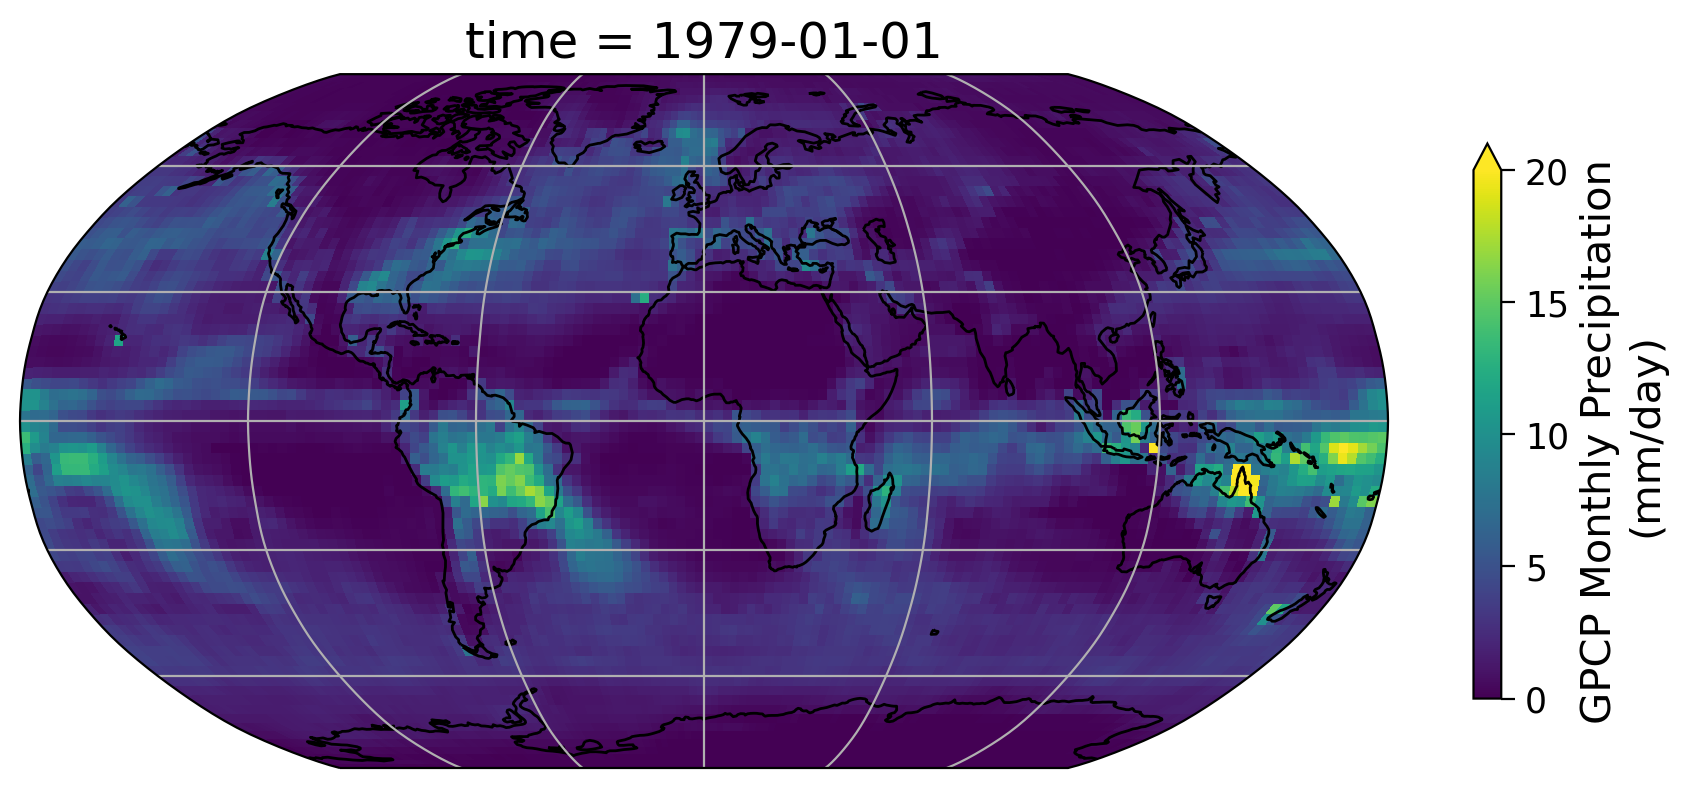

In [14]:
# visualize the precipitation data of a selected month using cartopy

# select data for the month of interest
data = precip.sel(time='1979-01-01', method='nearest')

# initate plot with the specific figure size
fig = plt.figure(figsize=(9,6))

# set base map projection
ax = plt.axes(projection=ccrs.Robinson())

# add coastal lines to indicate land/ocean
ax.coastlines()

# add major grid lines for latitude and longitute
ax.gridlines()

# add the precipitation data with map projection transformation
# also specify the maximum and minumum value show on the map to increase the
# contrast in the map.
data.plot(ax=ax, transform=ccrs.PlateCarree(),
          vmin=0, vmax=20, cbar_kwargs=dict(shrink=0.5, label='GPCP Monthly Precipitation \n(mm/day)'))

The updated map provides significant improvements, offering us a wealth of information to enhance our understanding of the GPCP monthly precipitation data. From the visualization, we can observe that regions such as the Amazon rainforest, the northern part of Australia, and other tropical areas exhibit higher levels of monthly precipitation in January 1979. These patterns align with our basic geographical knowledge, reinforcing the validity of the data and representation.

### **Coding Exercises 1.2**

Remember the GPCP also offers a data variable that documents the error of the monthly precipitation data used above. This error information is valuable for understanding the level of confidence we can place on the data. 

1. Generate the precipitation error for the same month (1979-01-01) using the examples provided above.

In [16]:
#################################################
# Students: Fill in missing code (...) and comment or remove the next line
raise NotImplementedError("Student exercise: Create precipitation error map for the month of January 1979 using GPCP monthly data.")
#################################################

# select data for the month of interest
data = ...

# initate plot
fig = ...

# set map projection
ax = ...

# add coastal lines to indicate land/ocean
...

# add grid lines for latitude and longitute
...

# add the precipitation data for
...

NotImplementedError: Student exercise: Create precipitation error map for the month of January 1979 using GPCP monthly data.

/Users/jennapearson/anaconda3/envs/climatematch/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


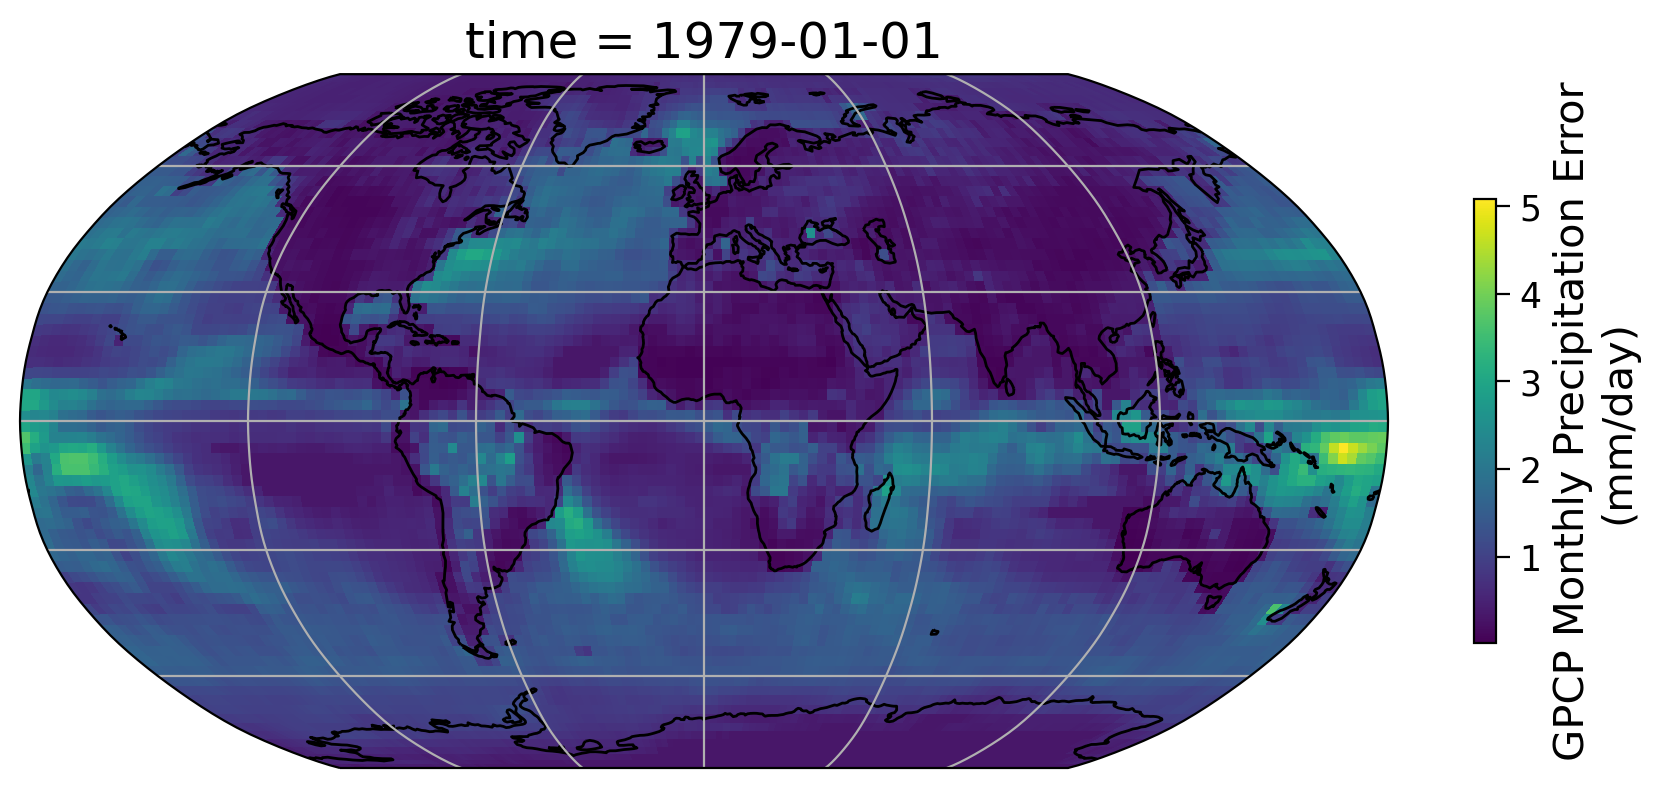

In [15]:
# to remove solution

# select data for the month of interest
data = ds.precip_error.sel(time='1979-01-01', method='nearest')

# initate plot
fig = plt.figure(figsize=(9,6))

# set map projection
ax = plt.axes(projection=ccrs.Robinson())

# add coastal lines to indicate land/ocean
ax.coastlines()

# add grid lines for latitude and longitute
ax.gridlines()

# add the precipitation data for
data.plot(ax=ax, transform=ccrs.PlateCarree(),
          cbar_kwargs=dict(shrink=0.4, label='GPCP Monthly Precipitation Error\n(mm/day)'))

### **Questions 1.2: Climate Connection**

1. Comment on the spatial pattern of the precipitation error provided by GPCP CDR data for this specific month. 
2. Which areas have the highest errors? Why do you think this might be?

In [17]:
# to_remove explanation

'''
1. Aside from the rainforested areas like the Amazon, southern Africa, and Indonesia the error on land is relatively low. Over the ocean the error seems to be concentrated in rain belts such as the Intertropical Convergence Zone you learned about on day 1 of this week, as well as over regions like the Gulf Stream area. The error of the ocean is generally higher than land.
2. This is a difficult question to answer. There are a number of things that affect the variability of preciptation estimate errors. This can include the rain regime (e.g. deep convection), the time of year, the terrain, and having observations to validate the data (which are more limited over the ocean) among other uncertainties.
'''

'\n1. Aside from the rainforested areas like the Amazon, southern Africa, and Indonesia the error on land is relatively low. Over the ocean the error seems to be concentrated in rain belts such as the Intertropical Convergence Zone you learned about on day 1 of this week, as well as over regions like the Gulf Stream area. The error of the ocean is generally higher than land.\n2. This is a difficult question to answer. There are a number of things that affect the variability of preciptation estimate errors. This can include the rain regime (e.g. deep convection), the time of year, the terrain, and having observations to validate the data (which are more limited over the ocean) among other uncertainties.\n'

# **Section 2: Climatology**

## **Section 2.1: Plot Time Series of Data at a Specific Location**

We have over 40 years of monthly precipitation data. Let's examine a specific location throughout the entire time span covered by the GPCP monthly data. For this purpose, we will focus on the data point located at (0°N, 0°E).

Text(0.5, 1.0, '')

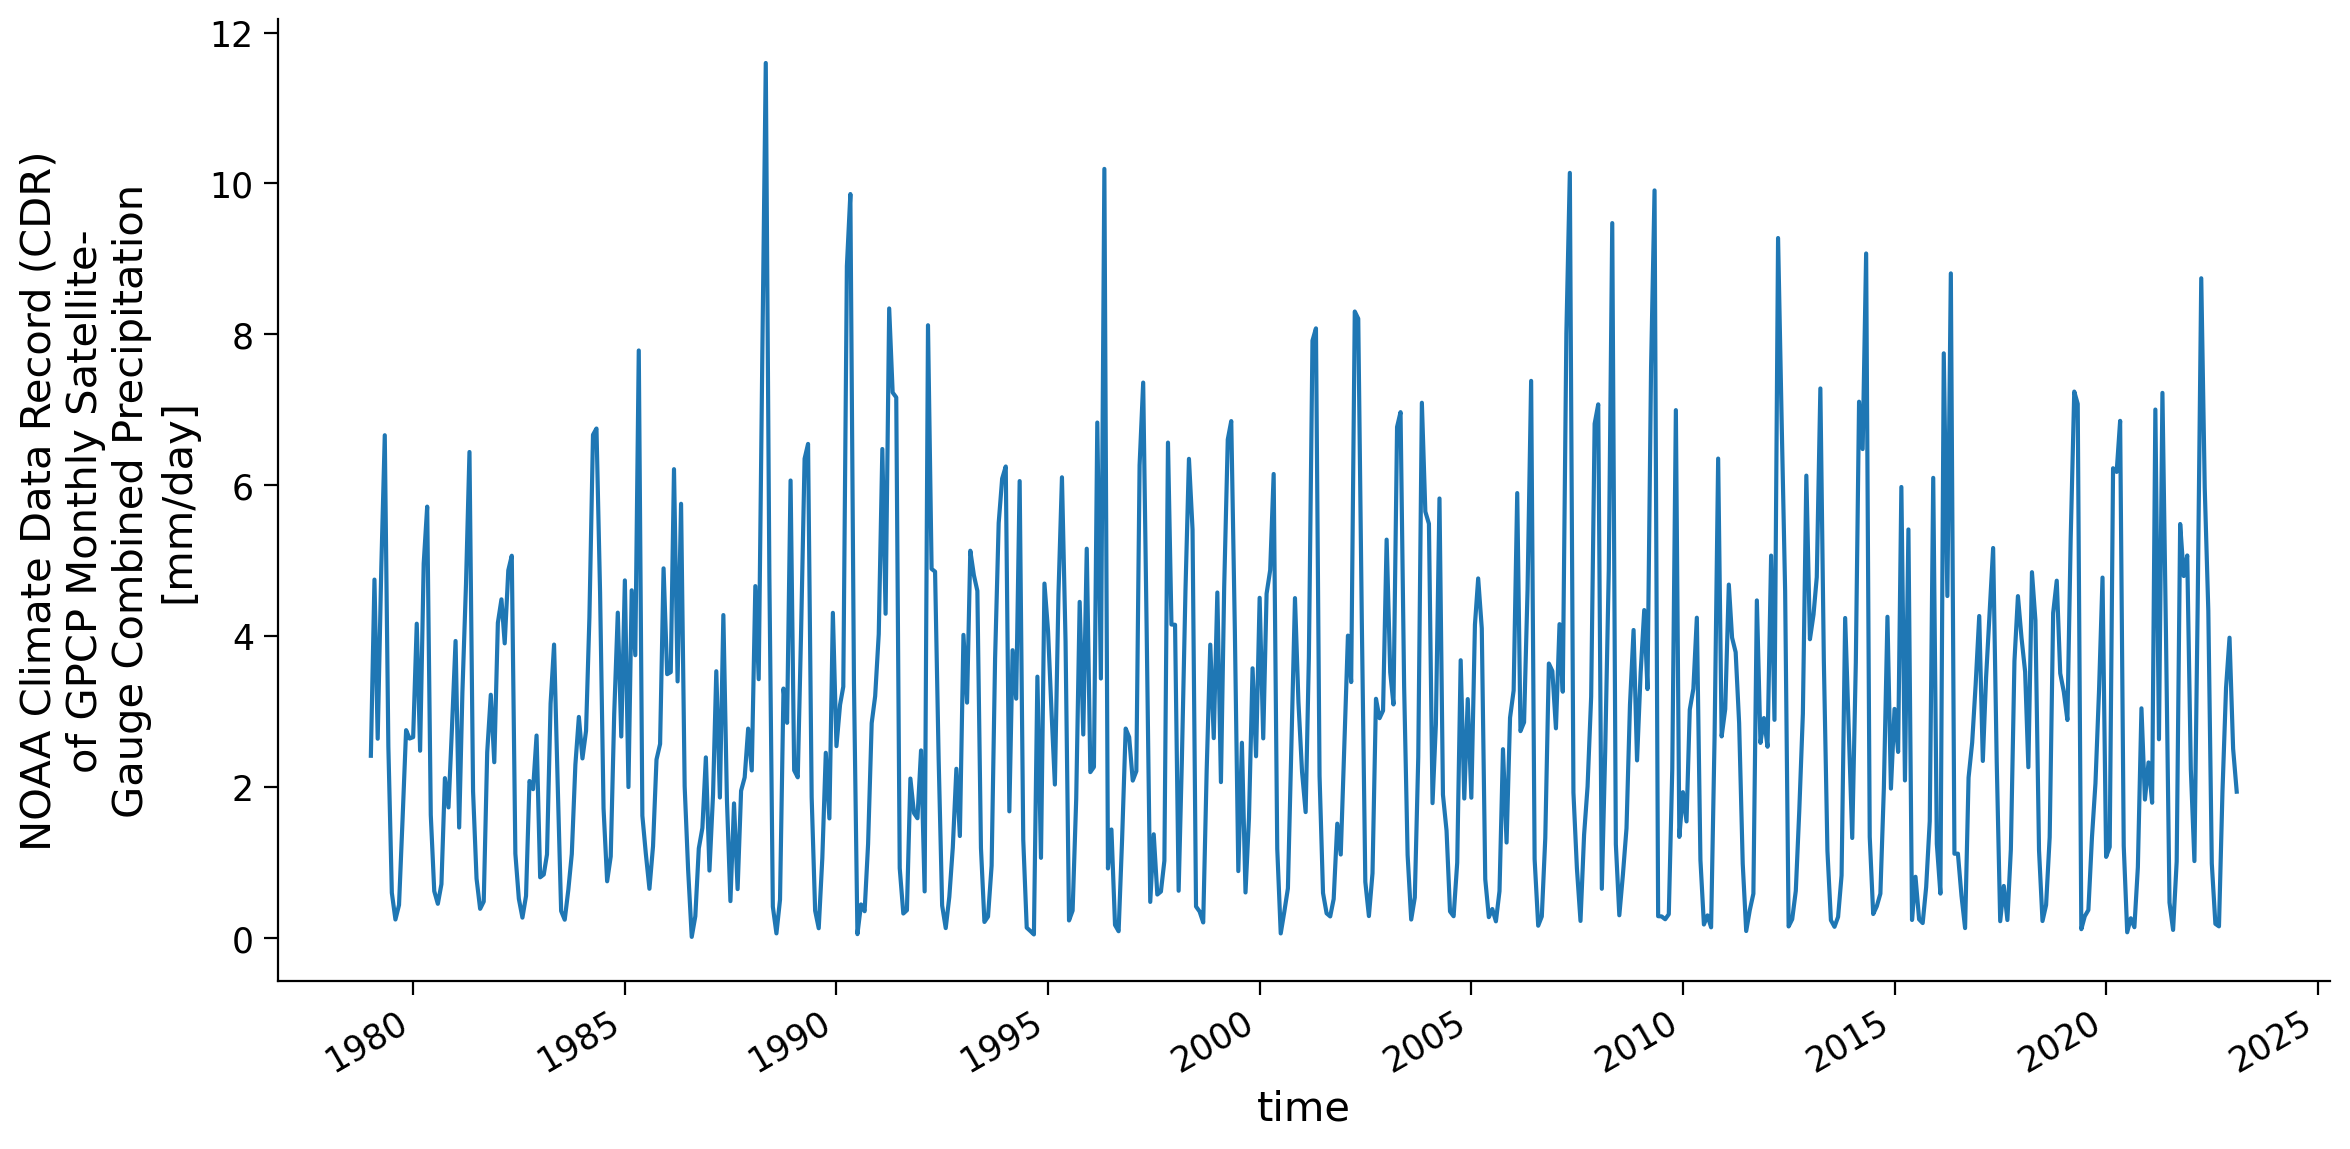

In [18]:
# select the entire time series for the grid that contains the location of (0N, 0E)
grid = ds.precip.sel(latitude=0, longitude=0, method='nearest')

# initate plot
fig = plt.figure(figsize=(12,6))

# plot the data
grid.plot()

# remove the automatically generated title
plt.title('')

From the time series plot, note a repeating pattern with a seasonal cycle (roughly the same ups and downs over the course of a year, for each year). In previous tutorials during the climate system overview you learned how to calculate climatology. We can apply this same calculation to the precipitation CDR data to investigate the annual cycle of precipitation at this location.

## **Section 2.2: Calculate the Climatology**

As a refresher, a climatology typically employs a 30-year time period to use for the calculation. In this case, let's use the reference period of 1981-2010.

In [21]:
# first, let's extract the data for the time period that we want (1981-2010)
precip_30yr = ds.precip.sel(time=slice('1981-01-01', '2010-12-30'))
precip_30yr

<xarray.DataArray 'precip' (time: 360, latitude: 72, longitude: 144)>
dask.array<getitem, shape=(360, 72, 144), dtype=float32, chunksize=(1, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time       (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2010-12-01
Attributes:
    long_name:      NOAA Climate Data Record (CDR) of GPCP Monthly Satellite-...
    standard_name:  precipitation amount
    units:          mm/day
    valid_range:    [  0. 100.]
    cell_methods:   area: mean time: mean

Now we can use Xarray's `.groupby()` functionality to calculate the monthly climatology.

Recall that `.groupby()` splits the data based on a specific criterion (in this case, the month of the year) and then applies a process (in our case, calculating the mean value across 30 years for that specific month) to each group before recombining the data together.

In [22]:
# use groupby to calculate monthly climatology (1981-2010)
precip_clim = precip_30yr.groupby('time.month').mean(dim='time')
precip_clim

<xarray.DataArray 'precip' (month: 12, latitude: 72, longitude: 144)>
dask.array<transpose, shape=(12, 72, 144), dtype=float32, chunksize=(1, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:      NOAA Climate Data Record (CDR) of GPCP Monthly Satellite-...
    standard_name:  precipitation amount
    units:          mm/day
    valid_range:    [  0. 100.]
    cell_methods:   area: mean time: mean

With the resulting climatology data array, we can make a set of maps to visualize the monthly climatology from four different seasons.

/Users/jennapearson/anaconda3/envs/climatematch/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


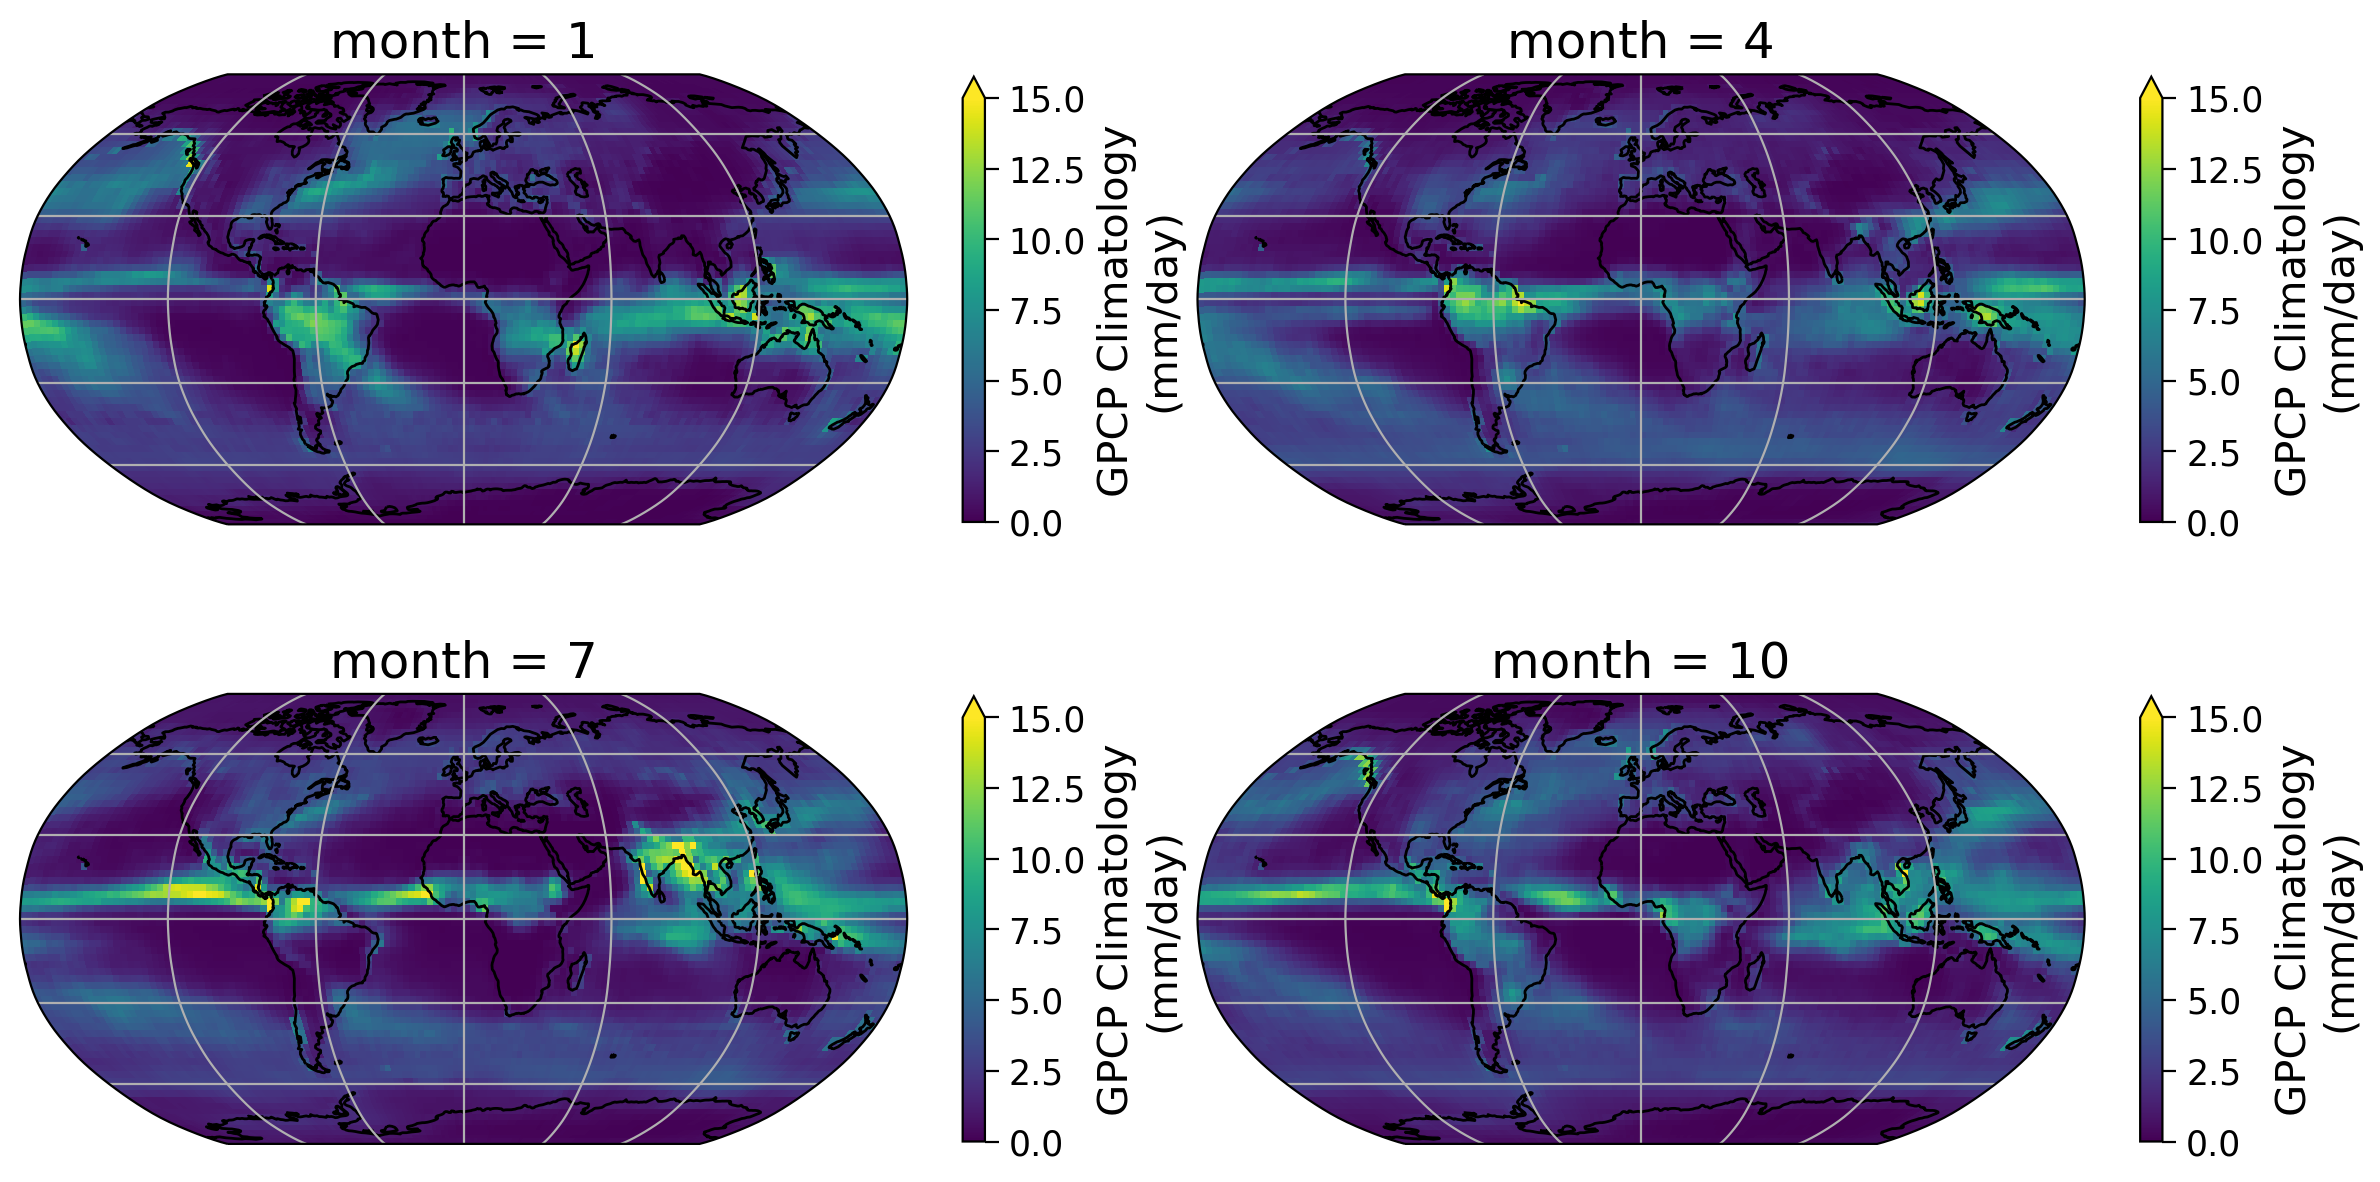

In [23]:
# define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.Robinson()},
                        figsize=(12,8))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

# loop over selected months (Jan, Apr, Jul, Oct)
for i,month in enumerate([1,4,7,10]):

        # Draw the coastines and major gridline for each subplot
        axs[i].coastlines()
        axs[i].gridlines()

        # Draw the precipitation data
        precip_clim.sel(month=month).plot(ax=axs[i], transform=ccrs.PlateCarree(),
                        vmin = 0, vmax = 15, # use the same range of max and min value
                        cbar_kwargs=dict(shrink=0.5, label='GPCP Climatology\n(mm/day)'))

In the seasonal collection of the climatology map, we can observe a clear pattern of precipitation across the globe. The tropics exhibit a higher amount of precipitation compared to other regions. Additionally, the map illustrates the seasonal patterns of precipitation changes across different regions of the globe, including areas influenced by monsoons.

### **Questions 2.2: Climate Connection**

1. Do the tropics or high-latitudes recieve more precipitation all year round? Why do you think this is? Think back to the climate system overview tutorials on atmospheric circulation to help form your answer.
2. In the climate system overview tutorials you learned about Monsoon systems in places such as India, South-east Asia and East Africa where there are notable wet and dry seasons. Do you see evidence of say, the Indian monsoon, in these maps?

In [24]:
# to_remove explanation

"""

1. The tropics receive more rain than the high-latiudes. The rain belt in the tropics is called the Intertropical Convergence Zone and is due to the ascending branches of Hadley cells near the equator. This rain belt propagates north and south following the suns maximum insolation point.
2. There is very strong precipitation noted over India in July, which is in keeping with the summer monsoon here. Drier conditions prevail in winter and spring.

"""

'\n\n1. The tropics receive more rain than the high-latiudes. The rain belt in the tropics is called the Intertropical Convergence zone and is due to the ascending branches of Hadley cells near the equator. This rain belt propagates north and south following the suns maximum insolation point.\n2. There is very strong precipitation noted over India in July, which is in keeping with the summer monsoon here. Drier conditions prevail in winter and spring.\n\n'

Now let's examine the climatology of the location we previously analyzed throughout the entire time series, specifically at (0°N, 0°E).

Text(0.5, 1.0, '')

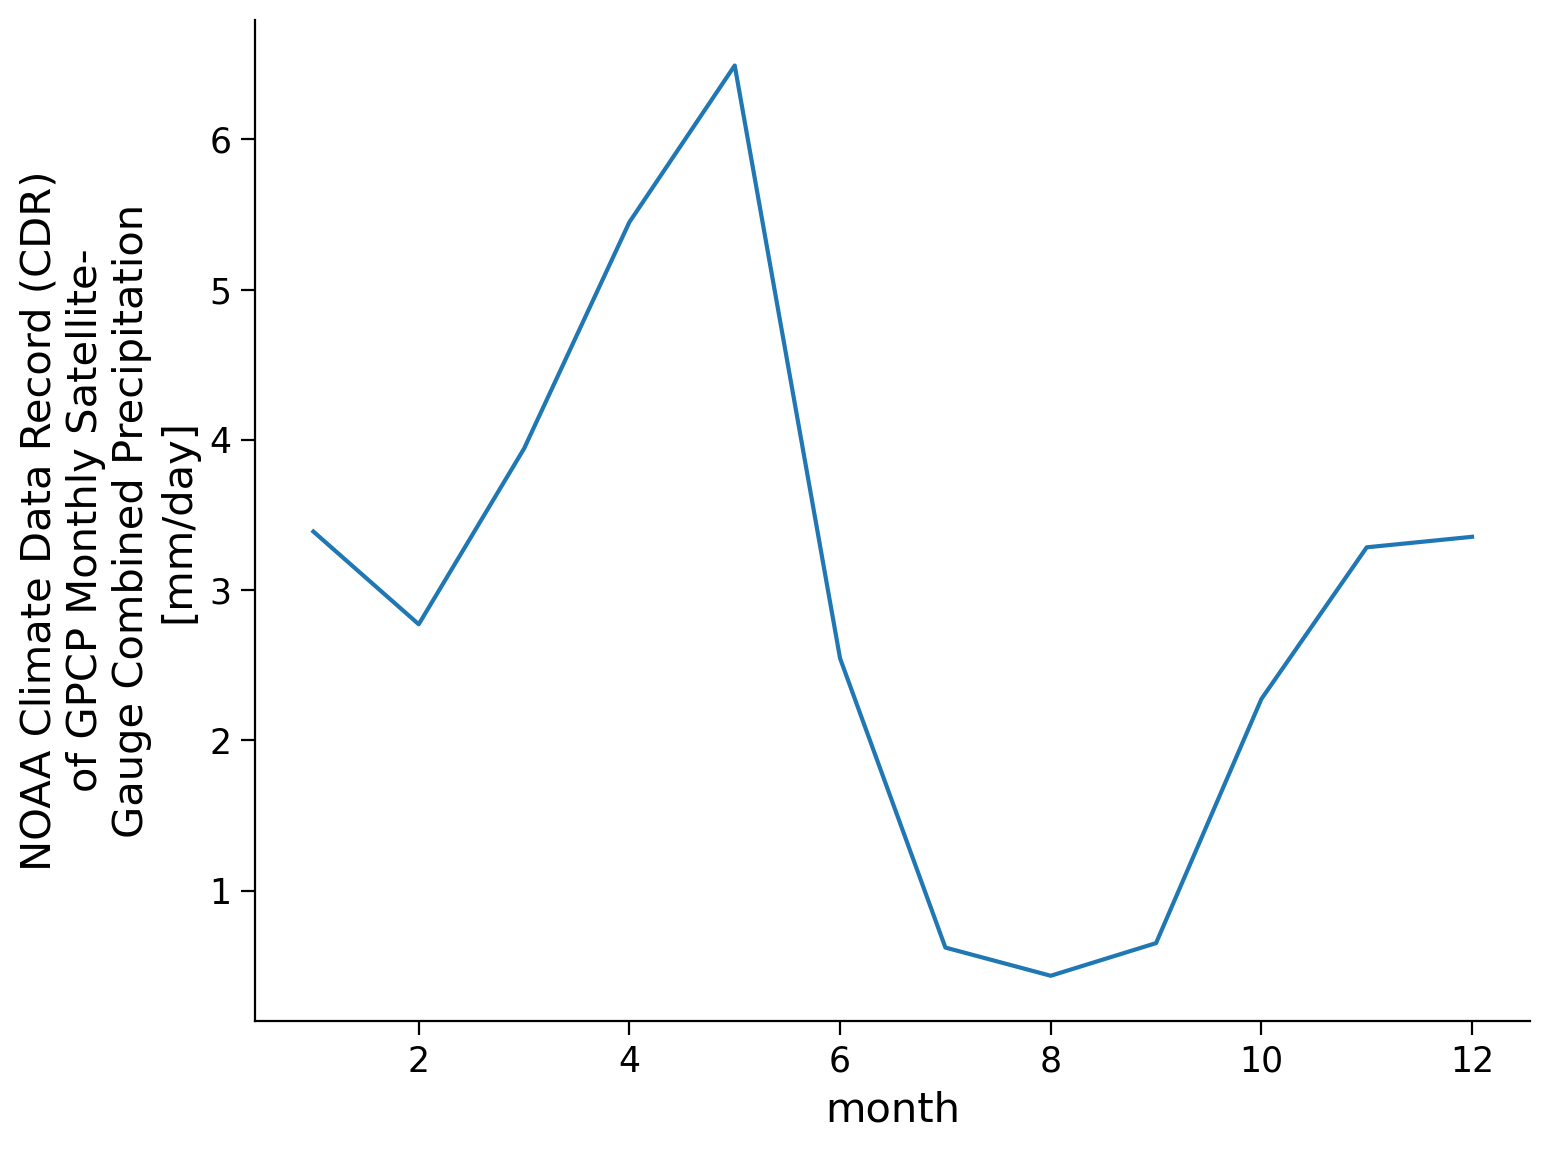

In [25]:
precip_clim.sel(latitude=0, longitude=0, method='nearest').plot()
# Remove the automatically generated title
plt.title('')


The monthly climatology time series for the point of interest demonstrates a noticeable seasonal pattern, with dry and rainy months observed in the region. Precipitation is typically more abundant between December and May, while August experiences the driest conditions throughout the year.


### **Coding Exercises 2.1**

As climate changes, the climatology of precipitation may also change. In fact, climate researchers recalculate climatology every 10 years. This allows climate scientists to monitor how the norms of our climate system change. In this exercise, you will visualize how the climatology of our dataset changes depending on the reference period used.

1. Calculate the climatology for a different reference period (1991-2020) and compare it to the climatology that we just generated with reference period (1981-2010). Be sure to compare the two and note differences. Can you see why it is important to re-calculate this climatology?


In [33]:
#################################################
# Students: Fill in missing code (...) and comment or remove the next line
raise NotImplementedError("Student exercise: Calculate the precipitation climatology for 1991-2020 and compare to the climatology using 1981-2010.")
#################################################

# extract 30 year data for 1991-2020
precip_30yr_exercise = ...

# calculate climatology for 1991-2020
precip_clim_exercise = ...

# find difference in climatologies: (1981-2010) minues (1991-2020)
precip_diff_exercise = precip_clim_exercise - precip_clim

# Compare the climatology for four different seasons by generating the
#         difference maps for January, April, July, and October with colorbar max and min = 1,-1

# define the figure and each axis for the 2 rows and 2 columns
...

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
...

#Loop over selected months (Jan, Apr, Jul, Oct)
...

NotImplementedError: Student exercise: Calculate the precipitation climatology for 1991-2020 and compare to the climatology using 1981-2010.

/Users/jennapearson/anaconda3/envs/climatematch/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


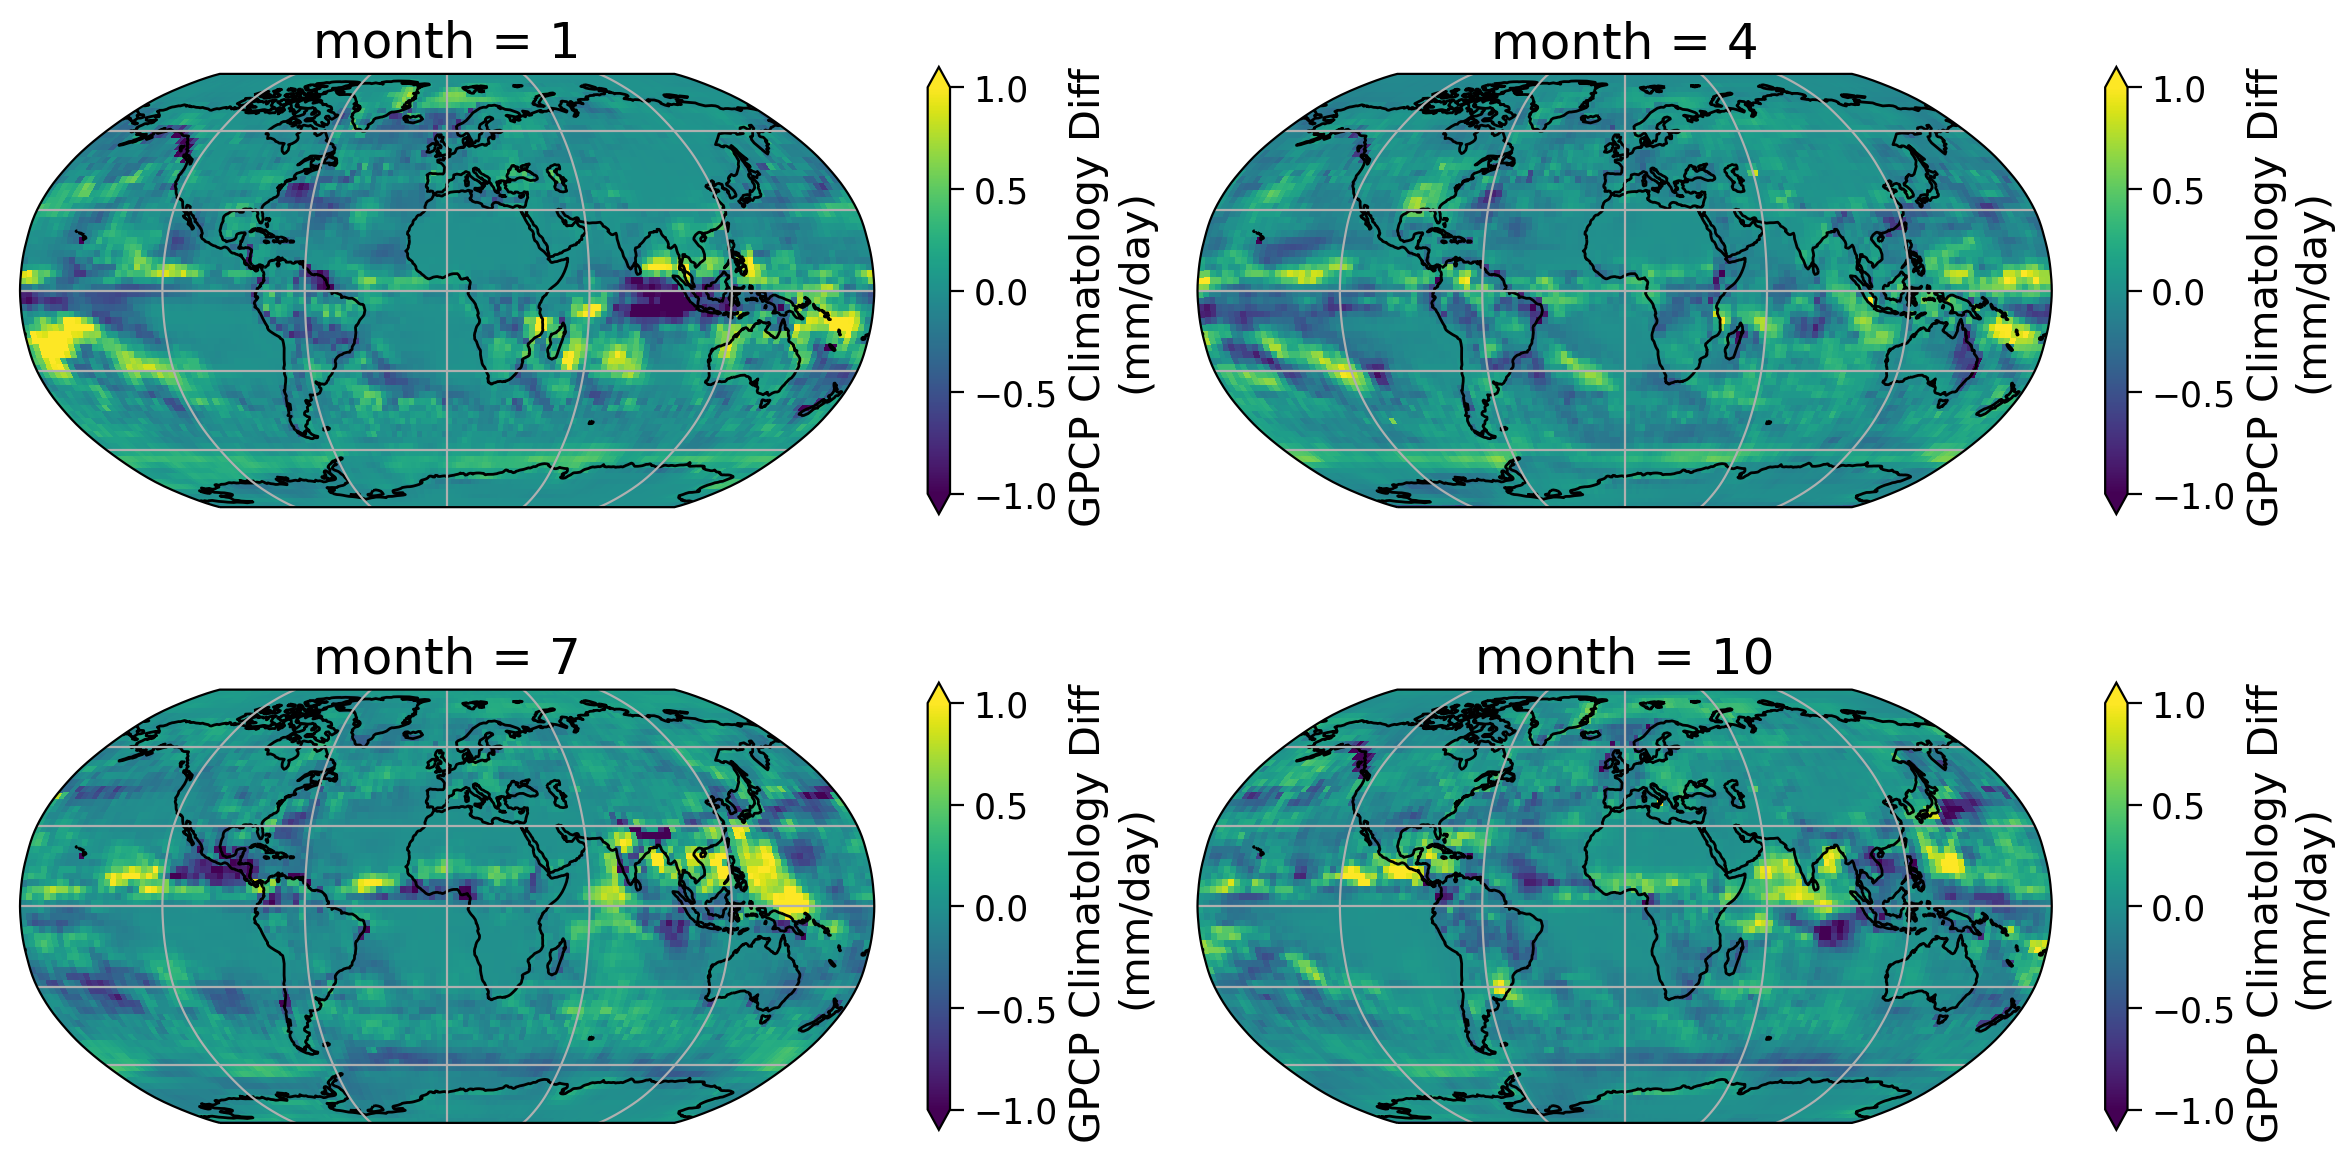

In [34]:
# to remove solution

# extract 30 year data for 1991-2020
precip_30yr_exercise = ds.precip.sel(time=slice('1991-01-01', '2020-12-30'))

# calculate climatology for 1991-2020
precip_clim_exercise = precip_30yr_exercise.groupby('time.month').mean(dim='time')

# find difference in climatologies: (1981-2010) minues (1991-2020)
precip_diff_exercise = precip_clim_exercise-precip_clim

# Compare the climatology for four different seasons by generating the
#         difference maps for January, April, July, and October with colorbar max and min = 1,-1

# Define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.Robinson()},
                        figsize=(12,8))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over selected months (Jan, Apr, Jul, Oct)
for i,month in enumerate([1,4,7,10]):

        # Draw the coastines and major gridline for each subplot
        axs[i].coastlines()
        axs[i].gridlines()

        # Draw the precipitation data
        precip_diff_exercise.sel(month=month).plot(ax=axs[i], transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1,
                        cbar_kwargs=dict(shrink=0.5, label='GPCP Climatology Diff \n(mm/day)'))


# **Summary**

Climatologies provide valuable insight into typical weather patterns of a region. Key takeaways from the tutorial include:

- A climatology pertains to the long-term average of various system attributes, such as temperature and precipitation, often spanning a duration of 30 years.
- Satellite climate data records offer valuable insights for calculating climatology on a global scale.

By comparing the weather conditions of a specific day or month to the climatology, we can determine the extent to which they deviate from the norm. This concept of comparing against the climatology, or the norm, will be the focus of our next tutorial - the anomaly!

# **Resources**

Data from this tutorial can be accessed [here](https://noaa-cdr-precip-gpcp-monthly-pds.s3.amazonaws.com/index.html#data/)